In [ ]:
# Analaysis behind Montana Free Press story
# As trade war simmers, Montana farmers get federal relief. Here’s where the 2019 subsidies hit home.
# https://montanafreepress.org/2020/01/07/as-trade-war-simmers-montana-farmers-get-federal-relief-heres-where-the-2019-subsidies-landed/

In [1]:
import pandas as pd
import altair as alt

alt.themes.enable('opaque')
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [4]:
df19 = pd.read_csv('../data/usda-2019-market-facilitation-payments.csv')

In [5]:
df19.head(3)

,Program Alpha Code,Payment Amount,Customer Name,State,County
0,19MFPNSCROPS,1819.20,GLENN OSTBY,Montana,ROOSEVELT
1,19MFPNSCROPS,4766.25,CARL E CLARK,Montana,TOOLE
2,19MFPNSCROPS,54726.15,CHRISTOPHER THOMAS HANSEN,Montana,ROOSEVELT


In [19]:
df19['Payment Amount'].describe()

count      9796.000000
mean      11618.688065
std       19792.579317
min           0.000000
25%        1040.475000
50%        3793.725000
75%       13591.882500
max      348056.700000
Name: Payment Amount, dtype: float64

In [6]:
df19['Program Alpha Code'].value_counts()

19MFPNSCROPS      8466
19MFPNSCROPSA     1141
19MFPLIVESTOCK     158
19MFPSPECIALTY      31
Name: Program Alpha Code, dtype: int64

In [7]:
# MT receipts for top 20% of farms
grouped = df19.groupby('Customer Name').agg(total=('Payment Amount', sum))
number = len(grouped)
top_20 = grouped.sort_values('total', ascending=False).head(int(number*0.2))
top_20['total'].sum() / df19['Payment Amount'].sum()

0.7007635410991491

In [9]:
# Total MT receipts, 2018
df19['Payment Amount'].sum()

113816668.28

In [10]:
# number of counties
len(df19['County'].unique())

53

In [11]:
# number of unique producers
len(df19['Customer Name'].unique())

8279

In [12]:
# biggest recipients
df19.groupby(['Customer Name','Program Alpha Code' ]).agg(payment=('Payment Amount', sum)).sort_values('payment', ascending=False).head(5)

,,payment
Customer Name,Program Alpha Code,
NEUFELD FARMS PARTNERSHIP,19MFPNSCROPS,348056.70
TORGERSON FARMS PARTNERSHIP,19MFPNSCROPS,316797.32
BROWN FARMS OF MONTANA,19MFPNSCROPS,268435.96
SPRINGWATER COLONY INC,19MFPNSCROPS,250000.00
PATRIOT FARMS,19MFPNSCROPS,242692.80


In [13]:
# Amount by program code
pc = df19.groupby('Program Alpha Code').agg(payments=('Payment Amount', sum), count=('Payment Amount', 'count'))
pc.style.format({"payments": "${:20,.0f}"})

,payments,count
Program Alpha Code,,
19MFPLIVESTOCK,"$ 1,986,752",158
19MFPNSCROPS,"$ 109,175,110",8466
19MFPNSCROPSA,"$ 2,561,006",1141
19MFPSPECIALTY,"$ 93,801",31


In [14]:
# Chouteau County
chouteau = df19[df19['County'] == 'CHOUTEAU']
print(len(chouteau['Customer Name'].unique()))
print(chouteau['Payment Amount'].sum())

588
9223405.540000001


In [15]:
# Sheridan County
sheridan = df19[df19['County'] == 'SHERIDAN']
print(len(sheridan['Customer Name'].unique()))
print(sheridan['Payment Amount'].sum())

389
8101553.970000001


In [16]:
# Garfield County
garfield = df19[df19['County'] == 'GARFIELD']
print(len(garfield['Customer Name'].unique()))
print(garfield['Payment Amount'].sum())

125
1425253.47


In [17]:
# Typical payment range for commodity crop growers
croppers = df19[df19['Program Alpha Code'] == '19MFPNSCROPS']
grouped = croppers.groupby('Customer Name').agg({'Payment Amount': sum})
grouped['Payment Amount'].describe()

count      7164.000000
mean      15239.406689
std       23305.147619
min           8.700000
25%        1687.200000
50%        6248.700000
75%       19465.612500
max      348056.700000
Name: Payment Amount, dtype: float64

In [18]:
# Payments to Tester
df19[df19['Customer Name'].str.contains('TESTER')]

,Program Alpha Code,Payment Amount,Customer Name,State,County
3409,19MFPNSCROPS,355.2,DAVID F TESTER,Montana,CHOUTEAU
5178,19MFPNSCROPS,2957.1,R JON TESTER,Montana,CHOUTEAU


In [26]:
# Top individual 5 recipients
by_recipient = df19.groupby(['Customer Name', 'County']).agg({'Payment Amount': sum})
by_recipient.sort_values('Payment Amount', ascending=False).head(10).style.format({"Payment Amount": "${:20,.0f}"})

,,Payment Amount
Customer Name,County,
NEUFELD FARMS PARTNERSHIP,VALLEY,"$ 348,057"
TORGERSON FARMS PARTNERSHIP,TOOLE,"$ 316,797"
SPRINGWATER COLONY INC,WHEATLAND,"$ 316,304"
HILLDALE COLONY INC,HILL,"$ 307,855"
BROWN FARMS OF MONTANA,ROOSEVELT,"$ 268,436"
PATRIOT FARMS,YELLOWSTONE,"$ 242,693"
NORTH HARLEM HUTTERIAN BRETHREN INC,BLAINE,"$ 238,887"
BIG ROSE COLONY INC,TOOLE,"$ 234,826"
GLACIER COLONY INC,GLACIER,"$ 220,826"


In [29]:
# Top county 5 recipients
# starting w/ by_recipient eliminates multiple payments to individuals

by_county = by_recipient.reset_index().groupby(['County']).agg(
    total_payments=('Payment Amount', sum),
    count_recipients=('Payment Amount', 'count')
)
# by_county = by_county.merge(farms, on='County', how='right').drop(columns=['county'])
# by_county['f_enrolled'] = by_county['count_payments'] / by_county['num_farms_17'] # apples to apples?

by_county.sort_values('total_payments', ascending=False).tail(10)

,total_payments,count_recipients
County,,
LAKE,209707.11,42
MADISON,149580.94,21
POWELL,108025.43,33
SWEET GRASS,73075.66,26
RAVALLI,65259.13,18
DEER LODGE,56110.34,15
GRANITE,39211.41,20
MISSOULA,6184.50,4
JEFFERSON,2714.86,4


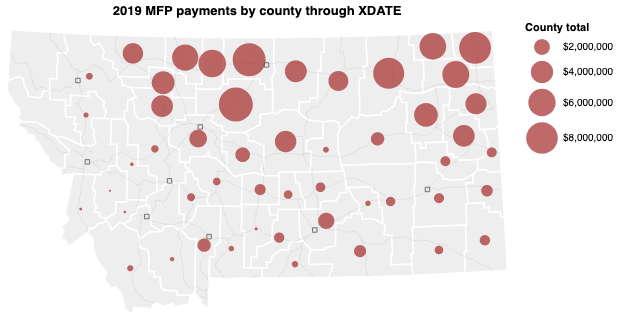

In [34]:
# County shapes
mt_counties_topojson_url = 'https://gist.githubusercontent.com/eidietrich/30118ba41ea41681948b06b0cf75864f/raw/9f8a2ed6d61d8ad7c42207ab4ef55a1e6548a909/mt-10m-counties.json'
county_lines = alt.topo_feature(mt_counties_topojson_url, 'counties')

# Highway paths
mt_highways_topojson_url = 'https://gist.githubusercontent.com/eidietrich/67cbe6196b6b87698fc42f50e96076ab/raw/4d51ceb627c76360497837e1ac5338698f7df752/ne_mt_highways_state_resolution.topojson.json'
highways = alt.topo_feature(mt_highways_topojson_url, 'highways')

# City point locations
cities = pd.read_csv('mt-major-cities.csv')

# County center point data
county_centroids = pd.read_csv('mt-county-centroids.csv').rename(columns={
    'NAME': 'County',
    'X': 'longitude',
    'Y': 'latitude'
})

# Merge circle size data with county center point data
point_data = by_county.merge(county_centroids[['County','longitude','latitude']], on='County')

# Sizing for circle marks
mfp_scale = scale=alt.Scale(domain=[0,8000000], range=[0,1000])

# County shapes
background = alt.Chart(county_lines).mark_geoshape(
    fill='#eee',
    stroke='white',
    strokeWidth=1.5,
)

# Road shapes
roads = alt.Chart(highways).mark_geoshape(
    stroke='#666',
    strokeWidth=1,
    opacity=0.1
)

# City points
cities = alt.Chart(cities).mark_square(size=20, fill='none', stroke='#444', strokeWidth=1).encode(
    longitude='longitude:Q',
    latitude='latitude:Q'
)

# Data circles
points = alt.Chart(point_data).mark_circle().encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    size=alt.Size('total_payments:Q', title='County total', scale=mfp_scale),
    color=alt.value('brown'),
    tooltip=['County', 'total_payments']
)

# Combine to single plot
(background + roads + cities + points).configure(numberFormat='$,.0f').configure_view(strokeOpacity=0).project(
    type='albers',
    rotate=[110,0]
).properties(
    width=500,
    height=300,
    title='2019 MFP payments by county through XDATE',  
)